In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

from darkgreybox.models import TiTe
from docs.tutorials.util.plot import plot

2021-03-30 13:33:27,340 darkgreybox  INFO     Logging enabled...


## Demo Notebook 02 - TiTe Model Direct Fit FAIL

This notebook demonstrates the direct usage of the `DarkGreyBox` models via a simple fitting example for a `TiTe` model. In this case a local minimum is found during the fitting process and the model heavily oscillates making it unusable.


Our temporal resolution is 1 hour

In [2]:
# the duration of a record
rec_duration = 1 # hour

Read some demo data.  
* Ph: Heating system power output
* Ta: Ambient temperature
* Ti: Internal temperature

Note: This demo data is intentionally far from ideal and particularly challenging to model with low errors. It is taken from a building where there are many factors influencing the heat dynamics of the building that are not accounted for in the modelling (solar gains, passive gains, hot water demand, gas use in the canteen etc.). The time period is relatively short to maintain a reasonable solution time for the demo. However, it includes an also challenging holiday period when the heating system is shut down.

In [3]:
train_df = pd.read_csv('./data/demo_data.csv', index_col=0, parse_dates=True)

input_X = train_df[['Ph', 'Ta', 'Th']]
input_y = train_df['Ti']

print(f'Input X shape: {input_X.shape}, input y shape: {input_y.shape}')

Input X shape: (792, 3), input y shape: (792,)


Use the `sklearn.model_selection.train_test_split` function to split the input data into train and test data. (Input data is 33 days long and 5 days of test data is specified)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(input_X, input_y, test_size=5 / 33, shuffle=False)

print(f'Train: X shape: {X_train.shape}, y shape: {y_train.shape}')
print(f'Test: X shape: {X_test.shape}, y shape: {y_test.shape}')

Train: X shape: (672, 3), y shape: (672,)
Test: X shape: (120, 3), y shape: (120,)


Set up the model training parameters.  

The `Ti0` param is the initial condition for the internal temperature at t=0 - this is set to the first value in `y_train` and is fixed, hence `vary: False`.  

The `Te0` param is the initial condition for the building envelope temperature at t=0 - this is set to the first value in `y_train` (as the inital estimate that `Te0` will be quite close to `Ti0`) and is NOT fixed, hence `vary: True`.  

`Ci`, `Ce`, `Rie` and `Ria` params are the initial conditions for these thermal parameters. As these will be fit by the model training their default is `vary: True`. The values for these params' initial conditions are set arbitrarily to `1` it is assumed that no estimates have been calculated for them (e.g. based on building physical properties).


In [5]:
train_params = {
    'Ti0': {'value': y_train.iloc[0], 'vary': False},
    'Te0': {'value': y_train.iloc[0], 'vary': True},
    'Ci': {'value': 1},
    'Ce': {'value': 1},
    'Rie': {'value': 1},
    'Rea': {'value': 1},
}

Instantiate the `TiTe` model and fit to the training data using the least-squares method.

In [6]:
model = TiTe(params=train_params, rec_duration=rec_duration) \
            .fit(X=X_train, y=y_train, method='leastsq')

Display the result of the fit: `Te0`, `Ci`, `Ce`, `Rie` and `Ria` params have been fit, however their errors are not calculated. This smells.

In [7]:
model.result.params

name,value,initial value,min,max,vary
Ti0,18.1375000,18.1375,-inf,inf,False
Te0,18.8031823,18.1375,-inf,inf,True
Ci,1.00652117,1,-inf,inf,True
Ce,0.95851117,1,-inf,inf,True
Rie,1.04365938,1,-inf,inf,True
Rea,0.98705055,1,-inf,inf,True


Get the training results by calling `predict` for the training data

In [8]:
train_results = model.predict(X=X_train)

Plot the modelled and measured data for the train set.  

As suspected, there is something wrong with the model and we get HUGE oscillations.  

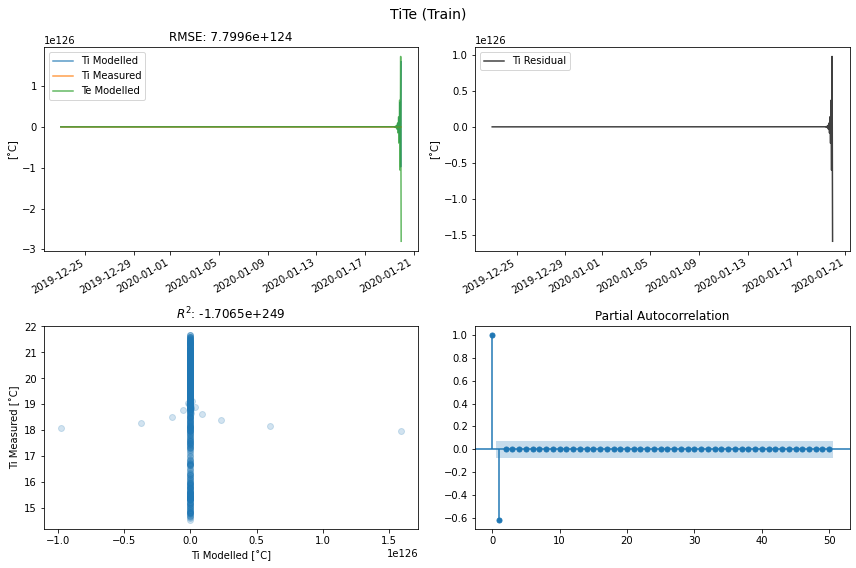

In [9]:
plot(y_train, train_results, 'TiTe (Train)')


As the models get more complex and the training data gets larger, the chances of the fitting process experiencing some sort of breakdown gets higher. If we had a set of better initial conditions (than the arbitrary 1s used here) for the model parameters, the fitting process would find the global minimum with a higher probability (and quicker).  

One option would be to try to calculate these parameters from the physical properties of the building. These data are not always available though, and each model type has a different set of parameters making this process really honourous.

The other option is the throw in an extra layer inspired by Genetic Algorithms and Machine Learning - which leads us to Demo 03.

We don't even need to carry on but...

In [10]:
test_results = model.predict(X=X_test, ic_params={'Ti0': y_test.iloc[0], 'Te0': train_results.Te[-1]})

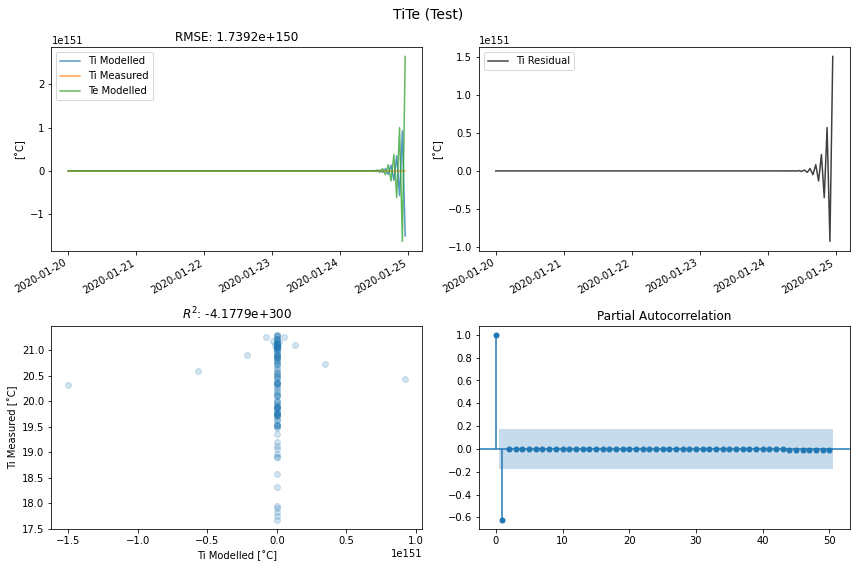

In [11]:
plot(y_test, test_results, 'TiTe (Test)')